This program downloads data from the Amazon cloud and produces a 4-panel plot. 

In [1]:
##Run this cell first, this loads/compiles the needed modules/functions
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from boto.s3.connection import S3Connection
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import cartopy.feature as cfeature
import gzip
from matplotlib import pyplot as plt
import shutil, os
from datetime import timedelta, datetime
import numpy as np
import tempfile
import pyart
def nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))


def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation 
    datetime_t : datetime
        desired date time
    """
    
    #First create the query string for the bucket knowing
    #how NOAA and AWS store the data
    
    my_pref = datetime_t.strftime('%Y/%m/%d/') + site
    
    #Connect to the bucket
    
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')
    
    #Get a list of files 
    
    bucket_list = list(bucket.list(prefix = my_pref))
    #print(bucket_list)
    #we are going to create a list of keys and datetimes to allow easy searching
    #print bucket_list
    keys = []
    datetimes = []
    
    #populate the list

    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-3]
            fmt = '%Y%m%d_%H%M%S_V06' 
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])
            #print(dt)
        if this_str[-3::] == 'V06': #'LSX20160707_000150_' does not match format '%Y%m%d_%H%M%S_V06'
            #print(this_str)
            #print(this_str[-19::])
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06' 
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])
    
    #function to allow easy searching 
    
    def func(x):
        delta =  x - datetime_t if x > datetime_t else timedelta.max
        return delta
    
    #find the closest available radar to your datetime 
    
    closest_datetime = nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)
    #print(closest_datetime)
    #create a temp file, download radar data to file from S3
    #read into a radar object and return
    
    localfile = tempfile.NamedTemporaryFile(delete=False)
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    name_str = str(bucket_list[index].key)
    return (radar,name_str[-22:-4])


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [30]:
## This retrieves the radar data and makes titles for the plot
b_d = datetime(2022,12,13,13,30) #datetime.utcnow() #datetime.strptime(base_date, fmt)
radar_name='KFWS'
my_radar = get_radar_from_aws(radar_name,b_d)

center_lon=my_radar[0].longitude['data'][0]-0.4 #Grab center coordinates of radar
center_lat=my_radar[0].latitude['data'][0]+0.05 #Grab center coordinates of radar

#Alternatively, you can use the lines below to specify the center coordinates
#center_lon=-97
#center_lat=48

#Define range around center coordinates to plot.  This is in degrees latitude/longitude
min_lat = center_lat-0.5
max_lat = center_lat+0.5
min_lon = center_lon-0.5
max_lon = center_lon+0.5
max_v=my_radar[0].fields['velocity']['data'].max()
display = pyart.graph.RadarMapDisplay(my_radar[0])

#Create Title for Plot
time_str = pyart.graph.common.generate_radar_time_begin(my_radar[0]).isoformat()
time_str = time_str[0:16]+'Z'
fixed_angle = my_radar[0].fixed_angle['data'][0]
figtitle = "%s %.1f Deg. %s " % (pyart.graph.common.generate_radar_name(my_radar[0]), fixed_angle,time_str)


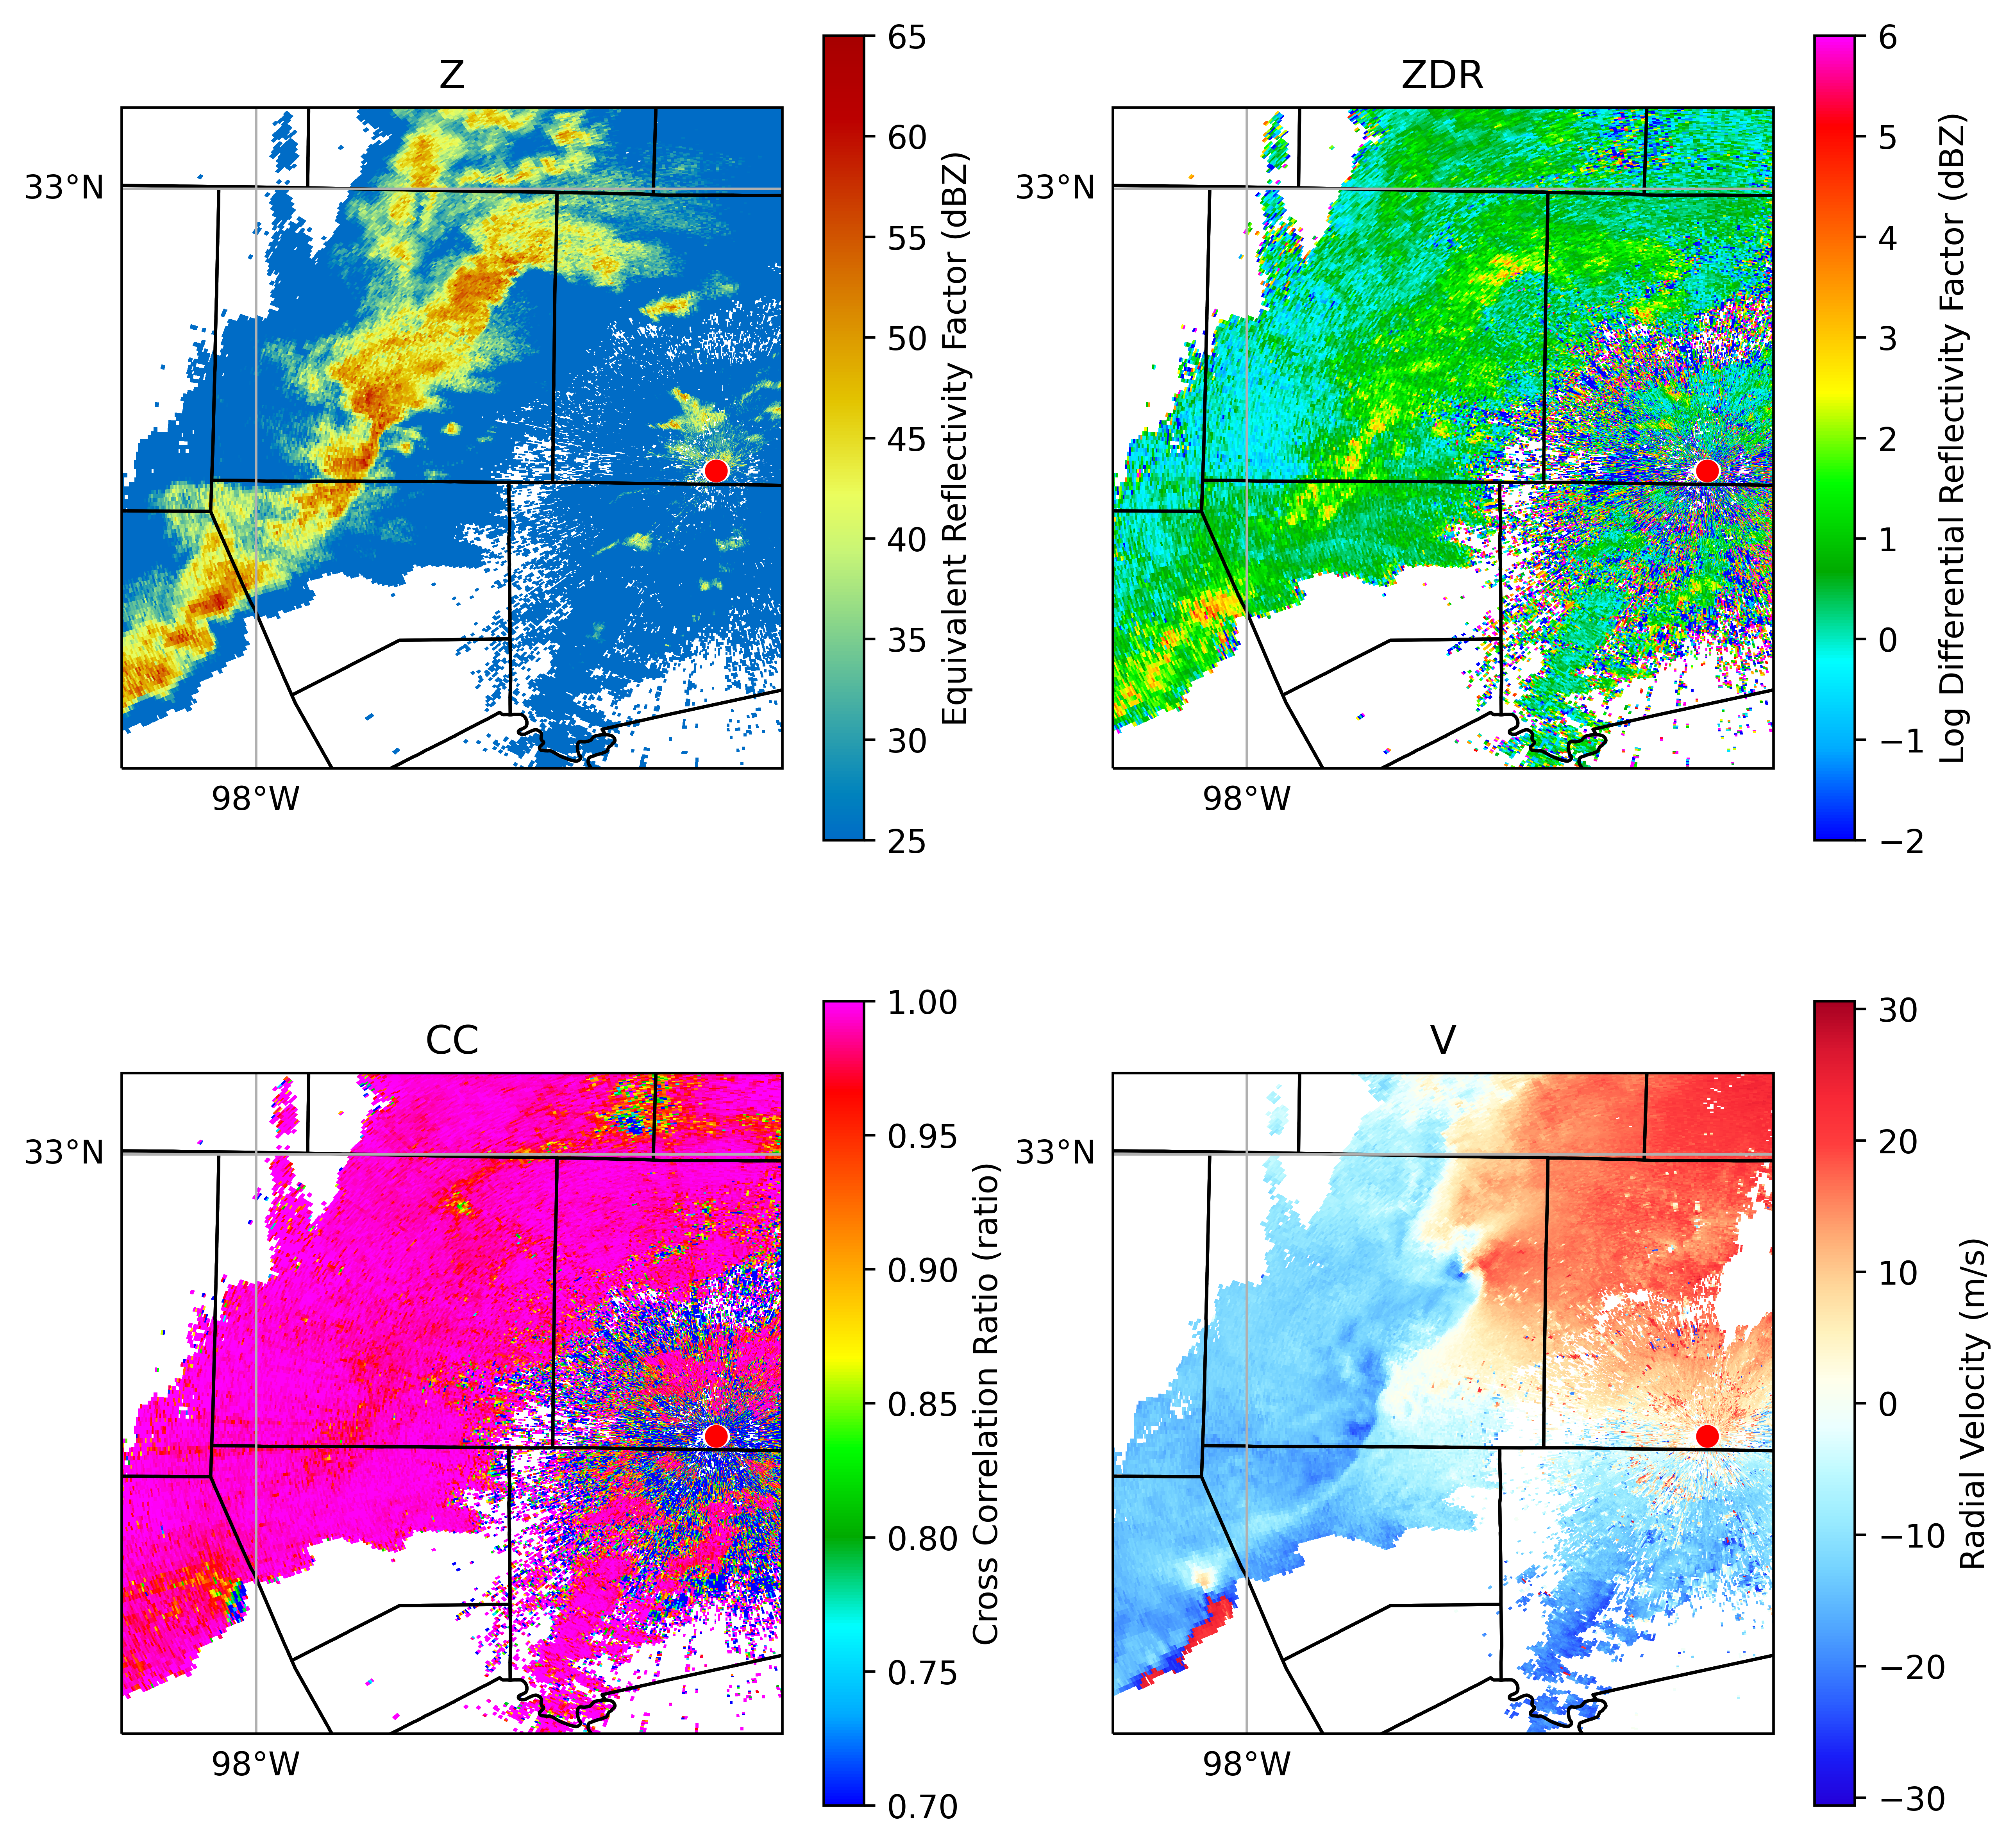

In [32]:
cname='data//shapes//tl_2017_us_county.shp'

counties = ShapelyFeature(Reader(cname).geometries(),
                                ccrs.PlateCarree(), edgecolor='black',facecolor='none')
#make the plot
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 10),dpi=600)  #Create figure
ax1 = fig.add_subplot(221,projection=projection) 
display.plot_ppi_map('reflectivity', 0, vmin=25, vmax=65,
                     min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
                     resolution='10m', projection=projection,colorbar_flag=1,
                     fig=fig, lat_0=center_lat,
                     lon_0=center_lon,title = 'Z',colorbar_label='Equivalent Reflectivity Factor (dBZ)', ax = ax1)
display.plot_point(my_radar[0].longitude['data'][0], my_radar[0].latitude['data'][0])
ax1.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black',linewidth=2)
ax1.add_feature(counties,linewidth=1)
ax2 = fig.add_subplot(222,projection=projection) 
display.plot_ppi_map('differential_reflectivity', 0, vmin=-2, vmax=6,
                     min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
                     resolution='10m', projection=projection,colorbar_flag=1,
                     fig=fig, lat_0=center_lat,
                     lon_0=center_lon,title = 'ZDR',colorbar_label='Log Differential Reflectivity Factor (dBZ)', ax = ax2)
display.plot_point(my_radar[0].longitude['data'][0], my_radar[0].latitude['data'][0])
ax2.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black',linewidth=2)
ax2.add_feature(counties,linewidth=1)
ax3 = fig.add_subplot(223,projection=projection) 
display.plot_ppi_map('cross_correlation_ratio', 0, vmin=0.7, vmax=1,
                     min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
                     resolution='10m', projection=projection,colorbar_flag=1,
                     fig=fig, lat_0=center_lat,
                     lon_0=center_lon,title = 'CC',colorbar_label='Cross Correlation Ratio (ratio)', ax = ax3)
display.plot_point(my_radar[0].longitude['data'][0], my_radar[0].latitude['data'][0])
ax3.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black',linewidth=2)
ax3.add_feature(counties,linewidth=1)
ax4 = fig.add_subplot(224,projection=projection) 
display.plot_ppi_map('velocity', 1, vmin=-0.9*max_v, vmax=0.9*max_v,
                     min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
                     resolution='10m', projection=projection,colorbar_flag=1,
                     fig=fig, lat_0=center_lat,
                     lon_0=center_lon,title = 'V',colorbar_label='Radial Velocity (m/s)', ax = ax4)
display.plot_point(my_radar[0].longitude['data'][0], my_radar[0].latitude['data'][0])
ax4.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black',linewidth=2)
ax4.add_feature(counties,linewidth=1)
plt.savefig('output//'+my_radar[1]+'.png',dpi=300) #saves file to image